In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import trackpy as tp
from skimage.io import imread
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import random as rand
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import math, random

In [2]:
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [18]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

image_num = str(58) #57 used, 88 used, 45, 46, 58 used for supp

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))

um_per_px = 2.2

In [15]:
#So track IDs and corrresponding tracks are found in tracking df, 
#The corresponding points that made the circle are in arcos df, 
#the waves to analze are in waves df, need to go from 
#WaveDF --> arcosDF --> trackingDF 
#Get centroid and radius over time from waveDF, 
#Get trackID inside wavefront from arcosDF, 
#Get track from tracking, then calc radial movement as enter wavefront? 

In [16]:
raw_tif = imread(images_folder / '{}.tif'.format(image_num))


<AxesSubplot:xlabel='timepoint', ylabel='circle_radius'>

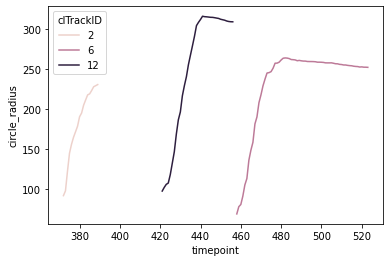

In [17]:
sns.lineplot(data=wave_df[wave_df['trackable']==True], x='timepoint', y='circle_radius', hue='clTrackID')

In [7]:
wave_df.clTrackID.unique()

array([ 2,  3, 11, 14, 22, 33, 20, 21, 25, 32])

In [19]:
#Lets select the example wave: (#image number: wave number)
ex_wave_num = 6 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]
start_time = ex_wave_DF.timepoint.min()
pre_wave_time = start_time - 12 #one min prior to wave
end_time = ex_wave_DF.timepoint.max()
post_wave_time = end_time + 2 #four min after wave

<AxesSubplot:xlabel='rel_time', ylabel='r_squared'>

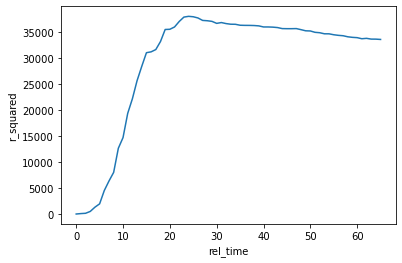

In [20]:
ex_wave_DF
sns.lineplot(data=ex_wave_DF, x='rel_time', y='r_squared')

In [27]:
export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 2/Stills/{}/'.format(image_num)
vmin_set = 175
vmax_set = 800
crop_buffer = 150 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10
ex_time = ex_wave_DF.timepoint.unique()[1] #57:182px, 81:160px,

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] == ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

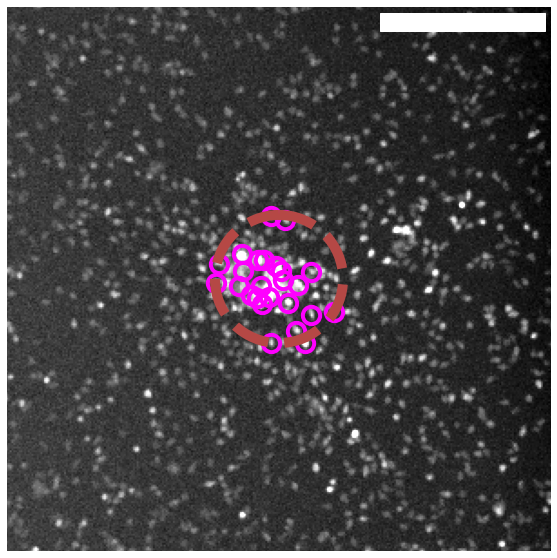

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raw_tif[ex_time, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=300, linewidth=4, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
circle1 = plt.Circle(initial_wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)



In [29]:
for t in ex_arcos_DF.timepoint.unique():
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(raw_tif[t, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
    ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] == t]
    
    #With circle fit overlay:
    i_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==t].wave_centroid.values[0]
    i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==t].circle_radius.values[0]/um_per_px
    circle1 = plt.Circle(i_wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
    ax.add_patch(circle1)
    
    #With ARCOS Points
    #sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor='magenta', s=100, linewidth=1, ax=ax) #57: 300,4; 88: 100, 1
    plt.axis('off')
    plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
    plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
    plt.gca().invert_yaxis()
    scalebar = AnchoredSizeBar(ax.transData,
                               100/um_per_px, '',  'upper right', 
                               pad=1,
                               color='white',
                               frameon=False,
                               size_vertical=10)

    ax.add_artist(scalebar)
    plt.savefig(export_location + image_num + '-{}-{}-wcircle.png'.format(ex_wave_num, t), dpi=500, bbox_inches='tight')
    plt.close(fig)

In [30]:
#Pre wave output: 
pre_wave_time = min(ex_arcos_DF.timepoint.unique()) - 12
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raw_tif[pre_wave_time, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] == pre_wave_time]
sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor='magenta', s=300, linewidth=4, ax=ax)
plt.axis('off')
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()
scalebar = AnchoredSizeBar(ax.transData,
                           100/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + image_num + '-{}-{}-wcircle.png'.format(ex_wave_num, pre_wave_time), dpi=300, bbox_inches='tight')
plt.close()